In [1]:
import os
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
import nltk

In [2]:
# Function to get continuous chunks of named entities
def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
            continuous_chunk.append(named_entity)

    return continuous_chunk

In [150]:
# Function to create a mapping from partial to full names
def create_name_mapping(character_df):
    name_mapping = {}
    for full_name in character_df['names']:
        name_mapping[full_name] = full_name
    
        parts = full_name.split()
        len_list = len(parts)
        
        if len_list != 0:
            for column in character_df[['first_name']]:
                columnSeriesObj = character_df[column]
                for value in columnSeriesObj.values:
                    if value == parts[0]:
                        name_mapping[value] = full_name
                    
        if len_list != 1:
            for column in character_df[['last_name']]:
                columnSeriesObj = character_df[column]
                for value in columnSeriesObj.values:
                    if value == parts[1]:
                        name_mapping[value] = full_name
                
    return name_mapping


In [151]:
# Function to filter entities and map partial names to full names
def filter_entity(entities, name_mapping):
    return [name_mapping.get(entity, entity) for entity in entities if entity in name_mapping]

In [152]:
def find_entities(book_text, character_df):
    # Create a mapping from partial names to full names
    name_mapping = create_name_mapping(character_df)
    print(name_mapping)
    # Tokenize the book text into sentences
    sentences = nltk.sent_tokenize(book_text)

    # Find entities in each sentence and map partial names to full names
    sent_entity_df = []
    for sent in sentences:
        entities = get_continuous_chunks(sent)
        full_names = filter_entity(entities, name_mapping)
        if full_names:  # Only add if there is at least one character entity in the sentence
            sent_entity_df.append({'sentence': sent, 'entity': full_names})
    
    # print(sent_entity_df)
    # Create a DataFrame from the list of sentences with entities
    sent_entity_df = pd.DataFrame(sent_entity_df)
    
    return sent_entity_df

In [153]:
def find_relationships(sent_entity_df):
    # Define a window size to look for relationships within
    window_size = 6# int(sent_entity_df.index.to_series().diff().mean())
    # print(window_size)
    # Initialize a list to hold relationships
    relationships = []

    # Loop through the sentences to find relationships within the window size
    for i in range(0, len(sent_entity_df) - window_size):
        window = sent_entity_df.iloc[i:i + window_size]
        all_entities = list(set(itertools.chain.from_iterable(window['entity'])))
        window_sentences = " ".join(window['sentence'])  # Combine sentences in the window
        for a, b in itertools.combinations(all_entities, 2):
            relationships.append({'source': min(a, b), 'target': max(a, b), 'sentence': window_sentences})

    # Create a DataFrame from the relationships
    relationships_df = pd.DataFrame(relationships)

    # Remove duplicate relationships
    relationships_df = relationships_df.drop_duplicates(subset=['source', 'target']).reset_index(drop=True)
    
    return relationships_df

In [154]:
def build_network(relationships_df):
    # If you wish to visualize the graph, continue with this part
    # Create a networkx graph from the relationships DataFrame
    G = nx.Graph()

    # Add edges from relationships_df to the graph
    for index, row in relationships_df.iterrows():
        G.add_edge(row['source'], row['target'])

    # Use a circular layout for the nodes
    d = dict(G.degree)
    # pos = nx.kamada_kawai_layout(G)

    # Draw the network
    plt.figure(figsize=(12, 12))
    # nx.draw_networkx(G, pos, with_labels=False)
    nx.draw_kamada_kawai(G, node_size=[v * 3 for v in d.values()],node_color = "Yellow", edge_color="grey", width=0.2, alpha=0.5)
    labels = nx.draw_networkx_labels(G, pos=nx.kamada_kawai_layout(G), font_size=7)
    # Display the plot
    plt.show()
    
    return G

In [155]:
def most_degree(G):
    # Calculate degree of each node
    degrees = dict(G.degree())

    # Sort nodes by degree in descending order
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Print the first 20 nodes with the highest degree
    print("Top 20 nodes by degree:")
    for node, degree in sorted_degrees[:30]:
        print(f"{node}: {degree}")

In [156]:
# Assuming 'data/books' contains your '.txt' files
all_books = [book for book in os.scandir('data/books') if book.name.endswith('.txt')]

# Initialize a list to hold the content of each book
book_text = []


# Loop through each book in the all_books list
for book in all_books:
    with open(book.path, encoding='utf-8') as file:  # Open the book file
        book_text.append(file.read())  # Read the content and add to the list

# Read the character names file
character_df = pd.read_csv('data/characters_fandom.csv')
character_df.rename(columns = {'name':'names'}, inplace = True)
character_df['names'] = character_df['names'].str.strip()

{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

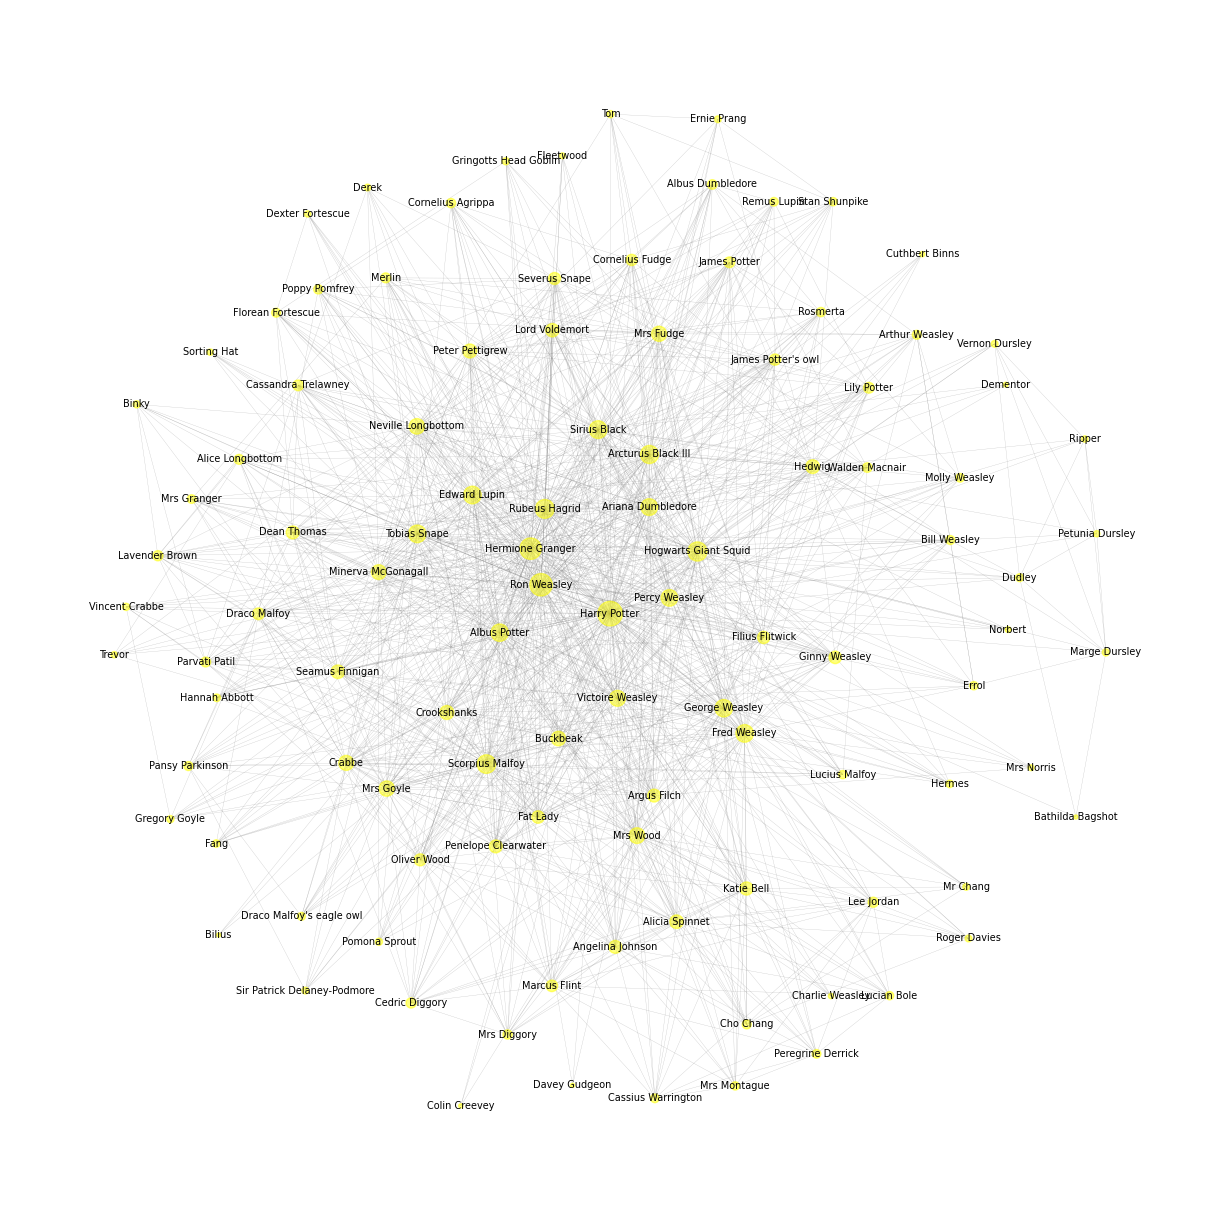

In [157]:
sent_entity_df = find_entities(book_text[0], character_df)
relationships_df = find_relationships(sent_entity_df)
G1 = build_network(relationships_df)

In [158]:
most_degree(G1)

Top 20 nodes by degree:
Harry Potter: 105
Ron Weasley: 87
Hermione Granger: 80
Hogwarts Giant Squid: 64
Rubeus Hagrid: 62
Scorpius Malfoy: 60
Arcturus Black III: 57
Sirius Black: 55
Fred Weasley: 54
Edward Lupin: 54
Tobias Snape: 54
George Weasley: 53
Albus Potter: 53
Ariana Dumbledore: 49
Percy Weasley: 48
Victoire Weasley: 44
Mrs Wood: 43
Neville Longbottom: 42
Mrs Goyle: 41
Mrs Fudge: 40
Crabbe: 39
Minerva McGonagall: 38
Buckbeak: 37
Crookshanks: 34
Peter Pettigrew: 34
Hedwig: 33
Seamus Finnigan: 32
Alicia Spinnet: 32
Lord Voldemort: 31
Katie Bell: 30


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

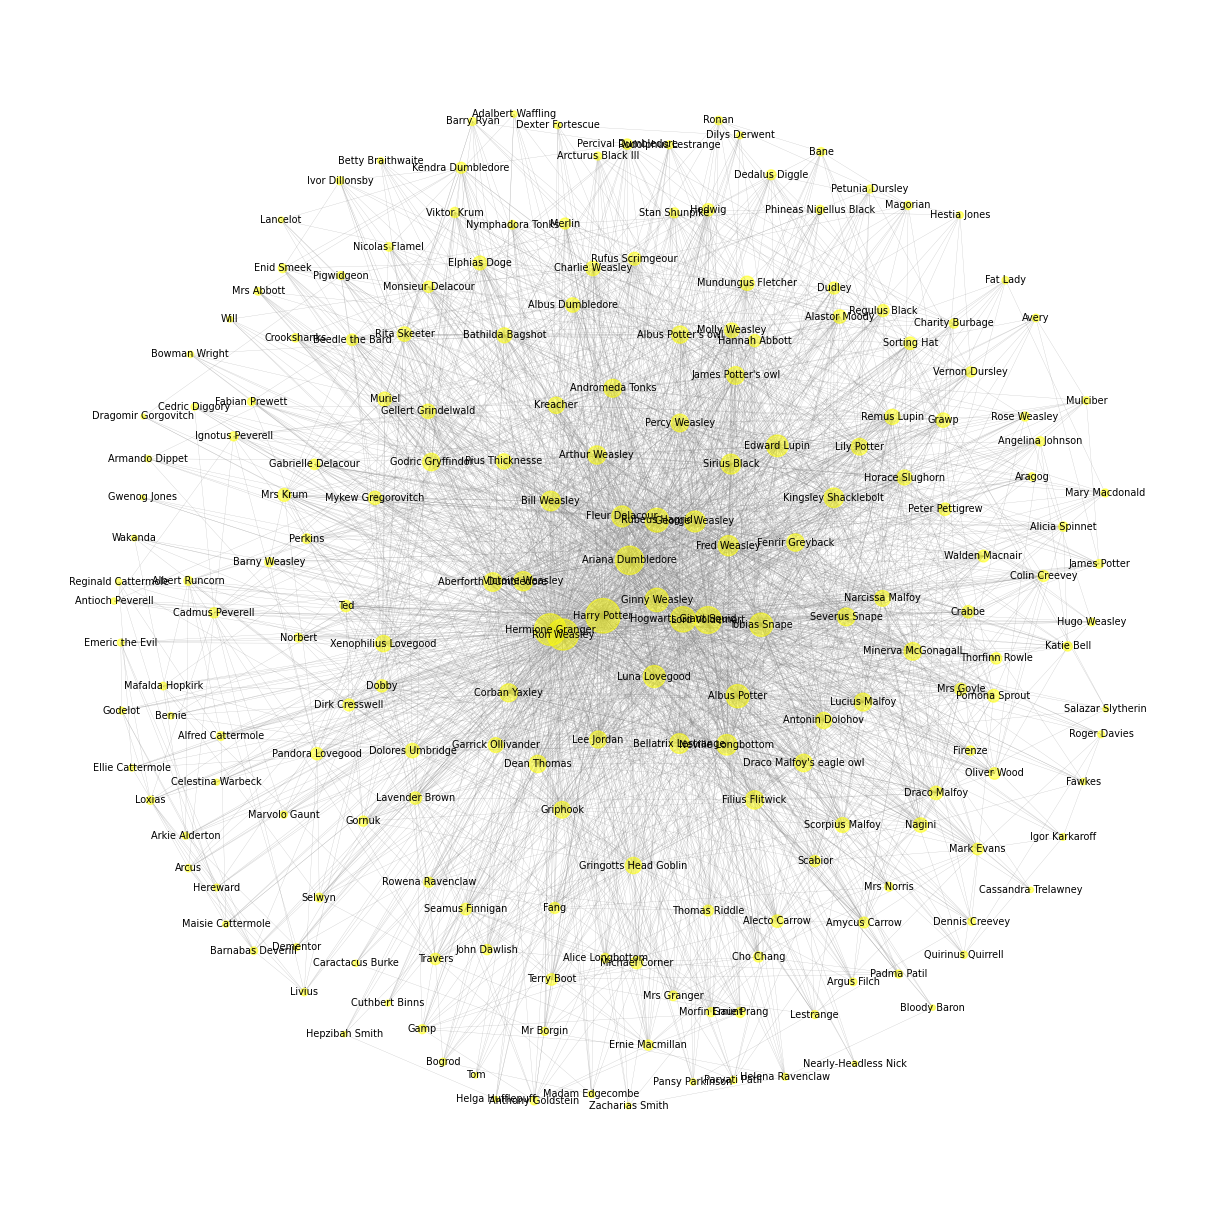

In [159]:
sent_entity_df = find_entities(book_text[1], character_df)
relationships_df = find_relationships(sent_entity_df)
G2 = build_network(relationships_df)

In [160]:
most_degree(G2)

Top 20 nodes by degree:
Harry Potter: 206
Hermione Granger: 174
Ron Weasley: 168
Ariana Dumbledore: 139
Lord Voldemort: 125
Hogwarts Giant Squid: 111
Rubeus Hagrid: 98
Ginny Weasley: 95
Tobias Snape: 94
Albus Potter: 93
Luna Lovegood: 84
Edward Lupin: 81
George Weasley: 75
Fleur Delacour: 75
Neville Longbottom: 73
Fred Weasley: 71
Sirius Black: 68
Bellatrix Lestrange: 67
Kingsley Shacklebolt: 66
Bill Weasley: 66
Victoire Weasley: 64
Aberforth Dumbledore: 60
Arthur Weasley: 58
Filius Flitwick: 58
Corban Yaxley: 56
Andromeda Tonks: 56
Lucius Malfoy: 55
Severus Snape: 55
James Potter's owl: 54
Percy Weasley: 54


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

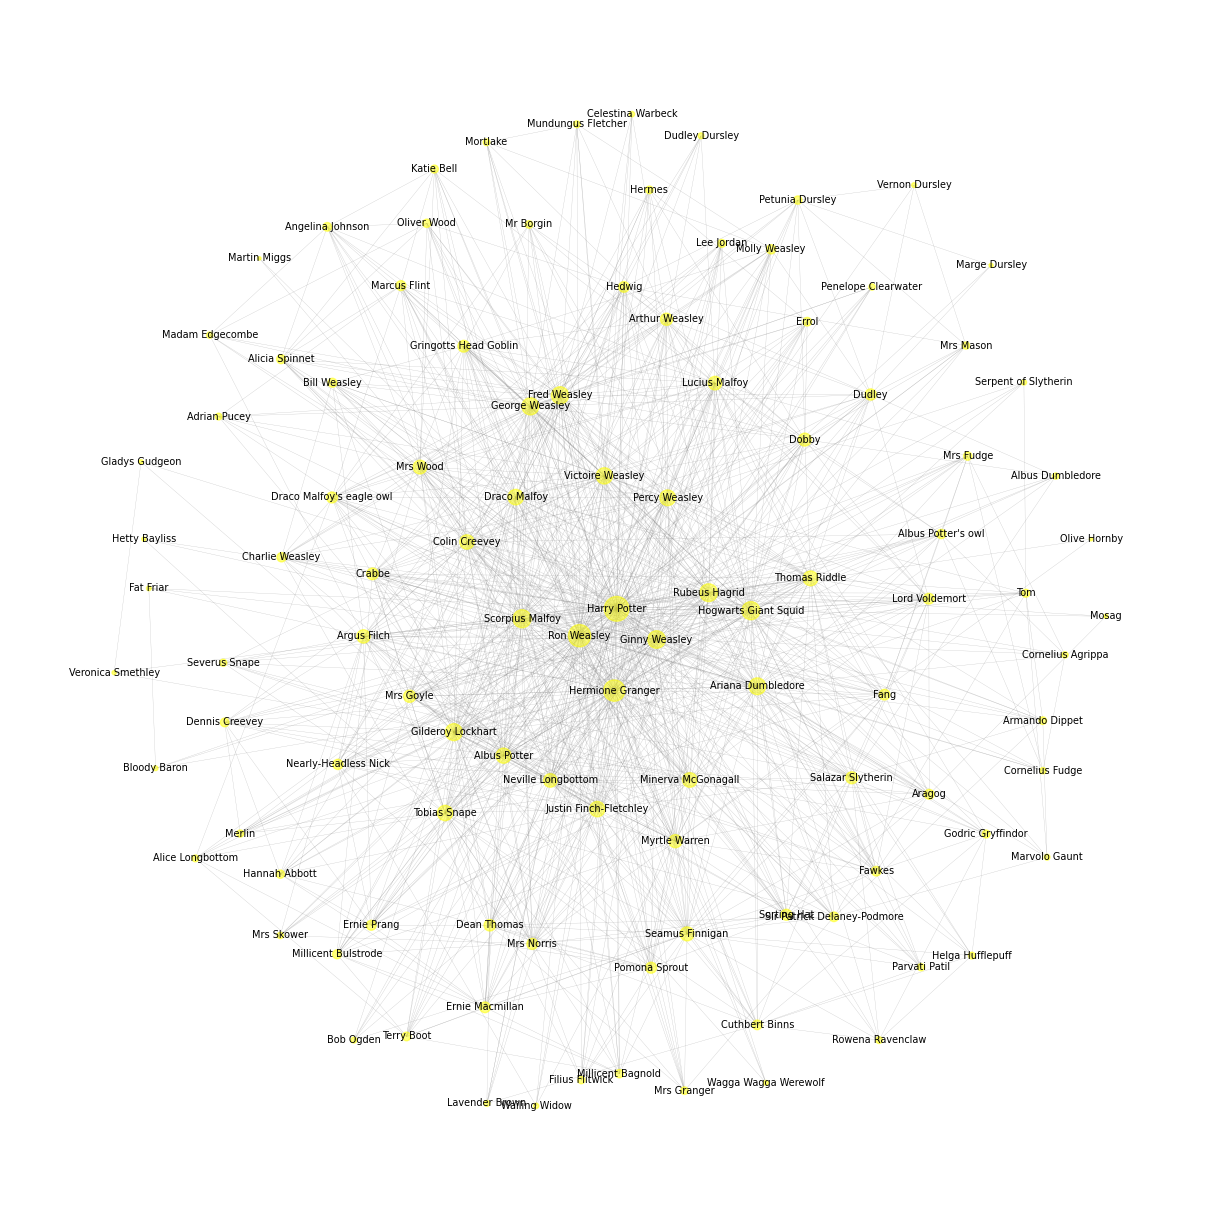

In [161]:
sent_entity_df = find_entities(book_text[2], character_df)
relationships_df = find_relationships(sent_entity_df)
G3 = build_network(relationships_df)

In [162]:
most_degree(G3)

Top 20 nodes by degree:
Harry Potter: 106
Ron Weasley: 86
Hermione Granger: 79
Hogwarts Giant Squid: 57
Scorpius Malfoy: 57
Rubeus Hagrid: 55
Ginny Weasley: 54
Fred Weasley: 52
George Weasley: 51
Gilderoy Lockhart: 50
Ariana Dumbledore: 49
Victoire Weasley: 46
Percy Weasley: 43
Draco Malfoy: 42
Tobias Snape: 41
Justin Finch-Fletchley: 41
Albus Potter: 40
Thomas Riddle: 38
Minerva McGonagall: 37
Colin Creevey: 36
Seamus Finnigan: 34
Mrs Wood: 33
Lucius Malfoy: 32
Neville Longbottom: 32
Argus Filch: 31
Myrtle Warren: 30
Dobby: 29
Arthur Weasley: 26
Mrs Goyle: 26
Salazar Slytherin: 25


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

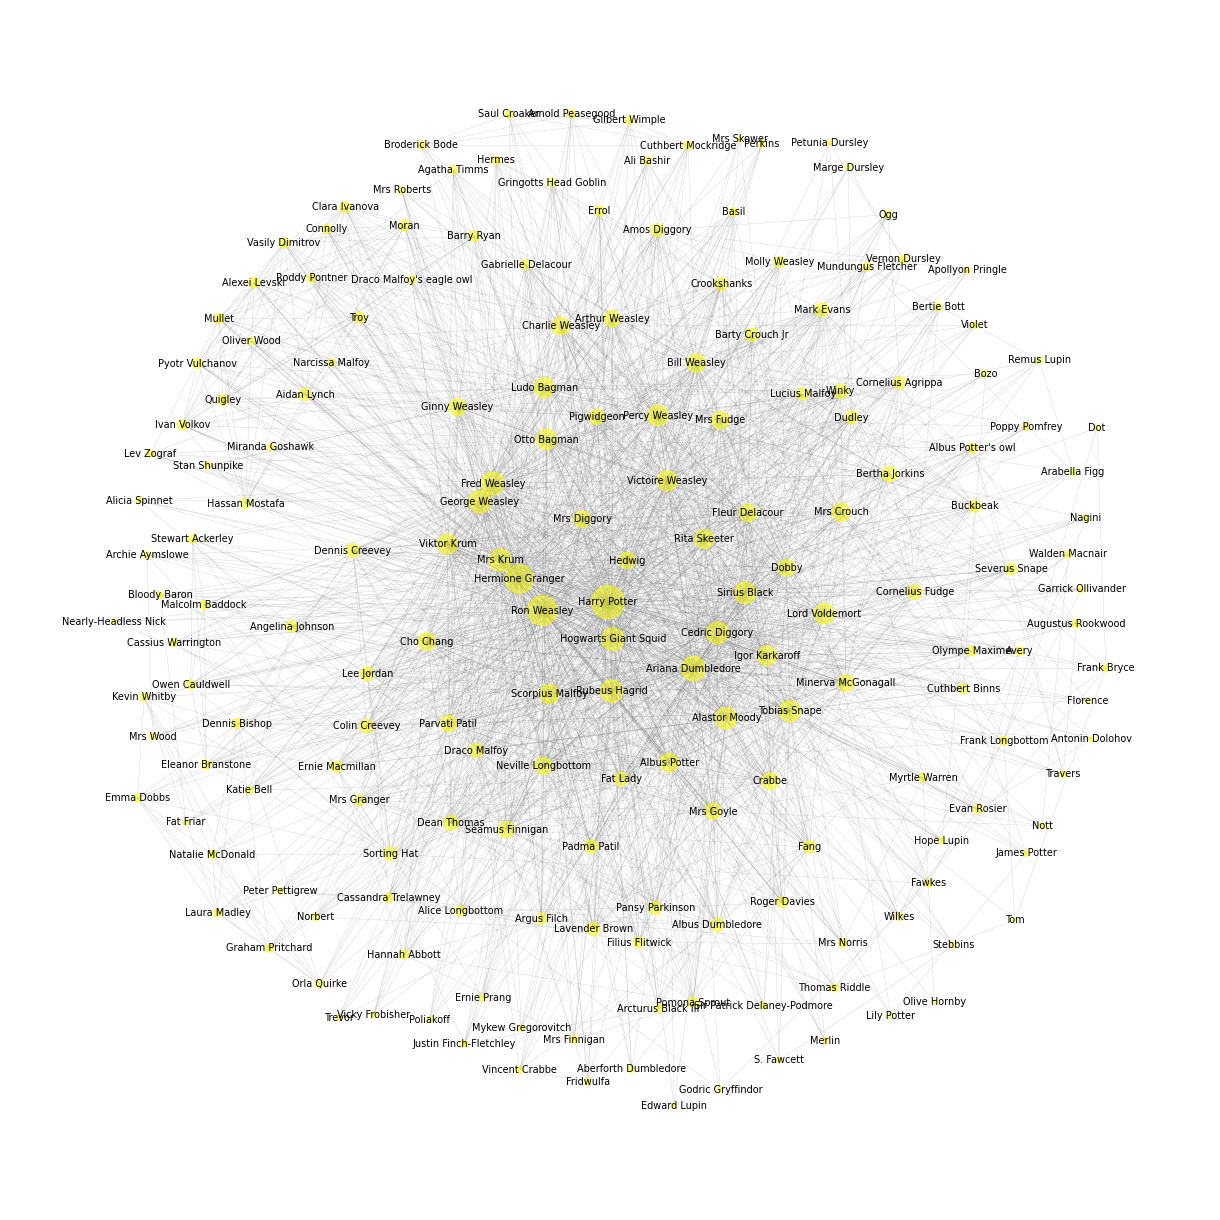

In [163]:
sent_entity_df = find_entities(book_text[3], character_df)
relationships_df = find_relationships(sent_entity_df)
G4 = build_network(relationships_df)

In [164]:
most_degree(G4)

Top 20 nodes by degree:
Harry Potter: 186
Ron Weasley: 149
Hermione Granger: 137
Ariana Dumbledore: 101
Fred Weasley: 88
Hogwarts Giant Squid: 87
George Weasley: 86
Rubeus Hagrid: 84
Mrs Krum: 83
Cedric Diggory: 82
Sirius Black: 80
Alastor Moody: 78
Tobias Snape: 76
Lord Voldemort: 70
Percy Weasley: 70
Otto Bagman: 70
Ludo Bagman: 69
Victoire Weasley: 67
Viktor Krum: 66
Igor Karkaroff: 64
Scorpius Malfoy: 62
Rita Skeeter: 61
Bill Weasley: 57
Albus Potter: 57
Mrs Crouch: 56
Charlie Weasley: 53
Cho Chang: 52
Mrs Fudge: 52
Fleur Delacour: 51
Ginny Weasley: 50


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

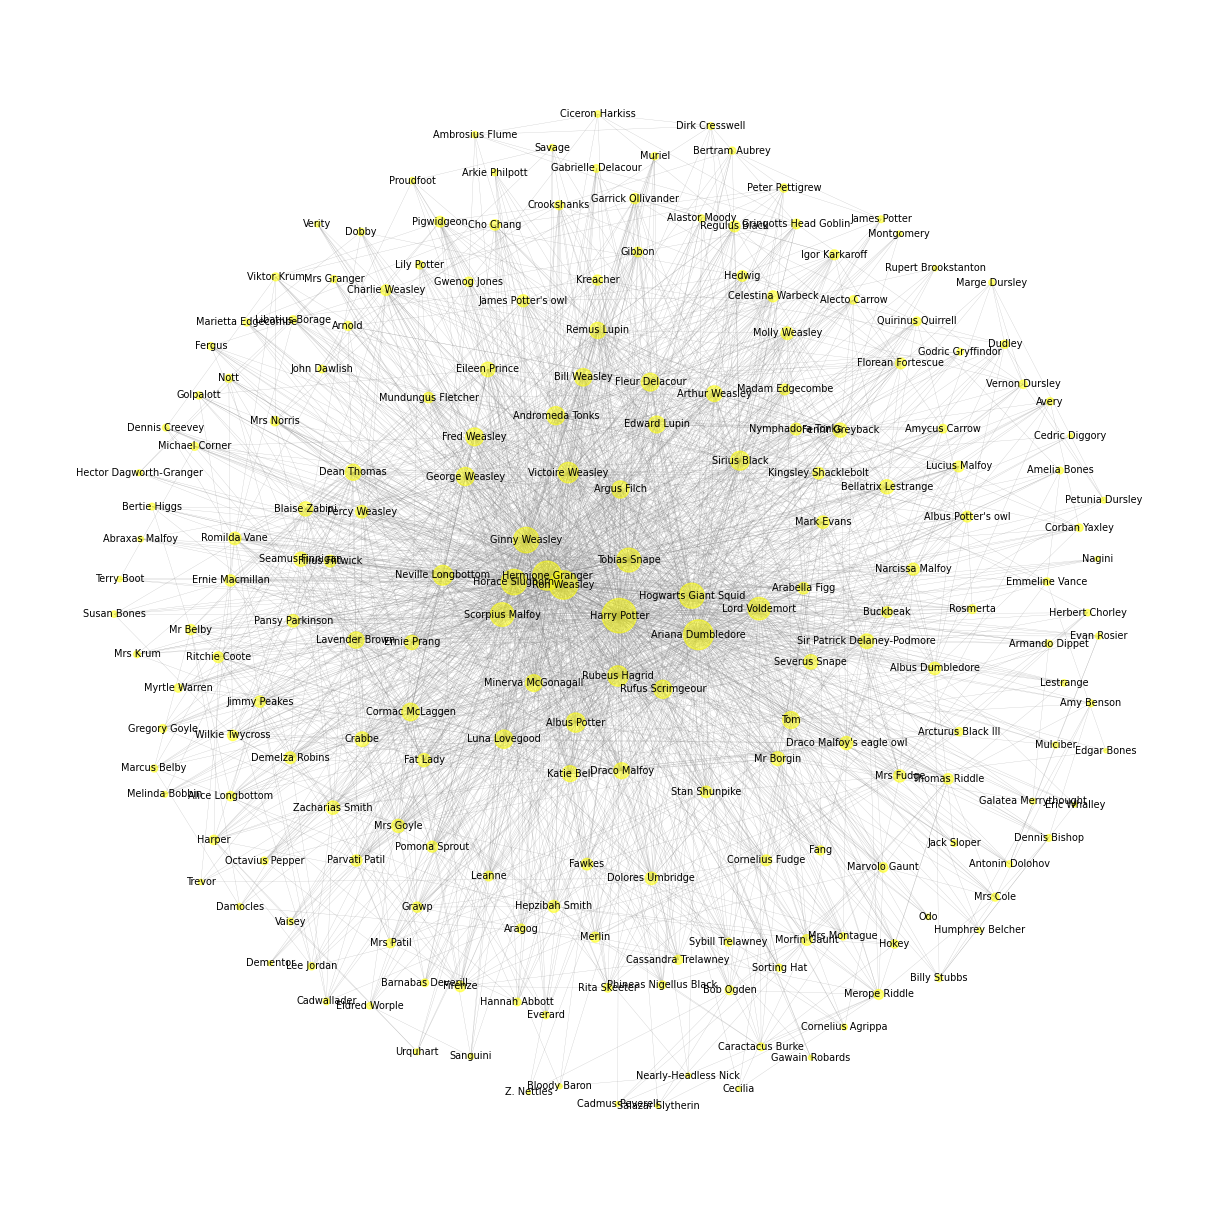

In [165]:
sent_entity_df = find_entities(book_text[4], character_df)
relationships_df = find_relationships(sent_entity_df)
G5 = build_network(relationships_df)

In [166]:
most_degree(G5)

Top 20 nodes by degree:
Harry Potter: 205
Ariana Dumbledore: 154
Hermione Granger: 146
Ron Weasley: 140
Horace Slughorn: 112
Ginny Weasley: 112
Hogwarts Giant Squid: 109
Tobias Snape: 99
Scorpius Malfoy: 97
Lord Voldemort: 87
Rubeus Hagrid: 72
Victoire Weasley: 72
Neville Longbottom: 68
Albus Potter: 64
Sirius Black: 62
Luna Lovegood: 58
Rufus Scrimgeour: 57
Andromeda Tonks: 57
George Weasley: 57
Fred Weasley: 55
Fleur Delacour: 55
Bill Weasley: 53
Cormac McLaggen: 53
Argus Filch: 51
Tom: 50
Edward Lupin: 49
Minerva McGonagall: 49
Lavender Brown: 46
Remus Lupin: 45
Dean Thomas: 45


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

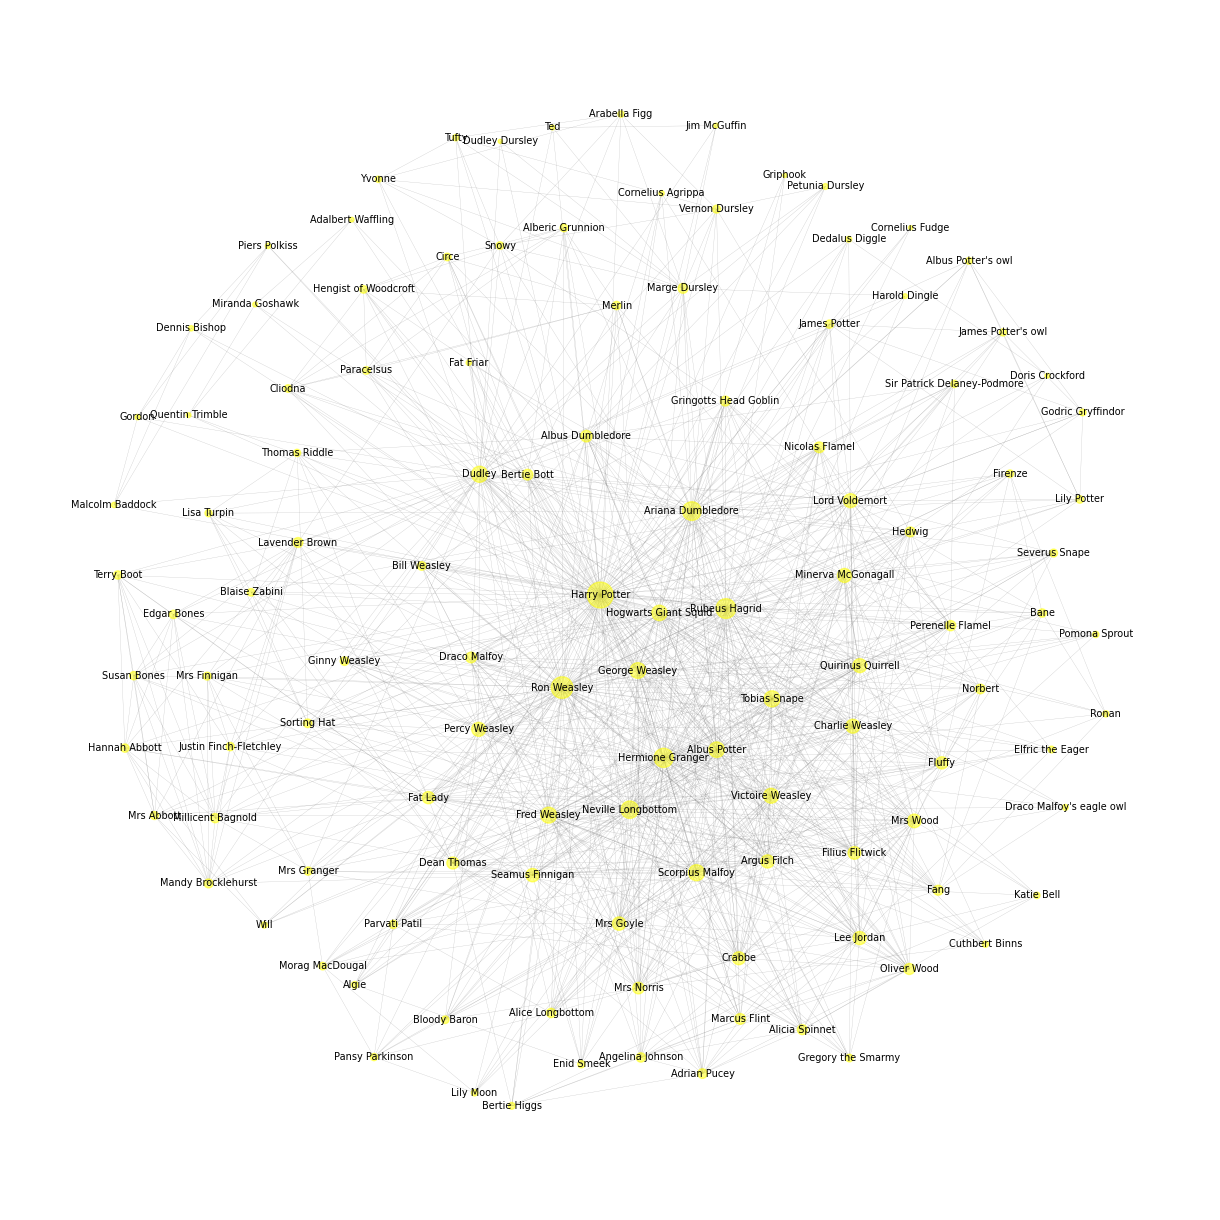

In [167]:
sent_entity_df = find_entities(book_text[5], character_df)
relationships_df = find_relationships(sent_entity_df)
G6 = build_network(relationships_df)

In [168]:
most_degree(G6)

Top 20 nodes by degree:
Harry Potter: 116
Ron Weasley: 81
Rubeus Hagrid: 68
Hermione Granger: 64
Ariana Dumbledore: 61
Neville Longbottom: 53
Dudley: 45
Scorpius Malfoy: 45
Tobias Snape: 45
Fred Weasley: 44
George Weasley: 43
Albus Potter: 42
Hogwarts Giant Squid: 41
Victoire Weasley: 39
Lord Voldemort: 34
Minerva McGonagall: 34
Quirinus Quirrell: 34
Percy Weasley: 34
Charlie Weasley: 34
Mrs Wood: 32
Mrs Goyle: 31
Seamus Finnigan: 31
Lee Jordan: 30
Argus Filch: 30
Crabbe: 29
Filius Flitwick: 28
Fat Lady: 26
Fluffy: 26
Dean Thomas: 25
Albus Dumbledore: 23


{'Vernon Dursley': 'Vernon Dursley', 'Vernon': 'Vernon Dursley', 'Dursley': 'Marge Dursley', 'Petunia Dursley': 'Petunia Dursley', 'Petunia': 'Petunia Dursley', 'Dudley Dursley': 'Dudley Dursley', 'Dudley': 'Dudley', 'Lily Potter': 'Lily Potter', 'Lily': 'Lily Potter', 'Potter': 'Albus Potter', 'James Potter': 'James Potter', 'James': "James Potter's owl", 'Harry Potter': 'Harry Potter', 'Harry': 'Harry Potter', 'Lord Voldemort': 'Lord Voldemort', 'Lord': 'Lord Voldemort', 'Voldemort': 'Lord Voldemort', 'Jim McGuffin': 'Jim McGuffin', 'Jim': 'Jim McGuffin', 'McGuffin': 'Jim McGuffin', 'Ted': 'Ted', 'Albus Dumbledore': 'Albus Dumbledore', 'Albus': "Albus Potter's owl", 'Dumbledore': 'Ariana Dumbledore', 'Minerva McGonagall': 'Minerva McGonagall', 'Minerva': 'Minerva McGonagall', 'McGonagall': 'Minerva McGonagall', 'Dedalus Diggle': 'Dedalus Diggle', 'Dedalus': 'Dedalus Diggle', 'Diggle': 'Dedalus Diggle', 'Poppy Pomfrey': 'Poppy Pomfrey', 'Poppy': 'Poppy Pomfrey', 'Pomfrey': 'Poppy Pomf

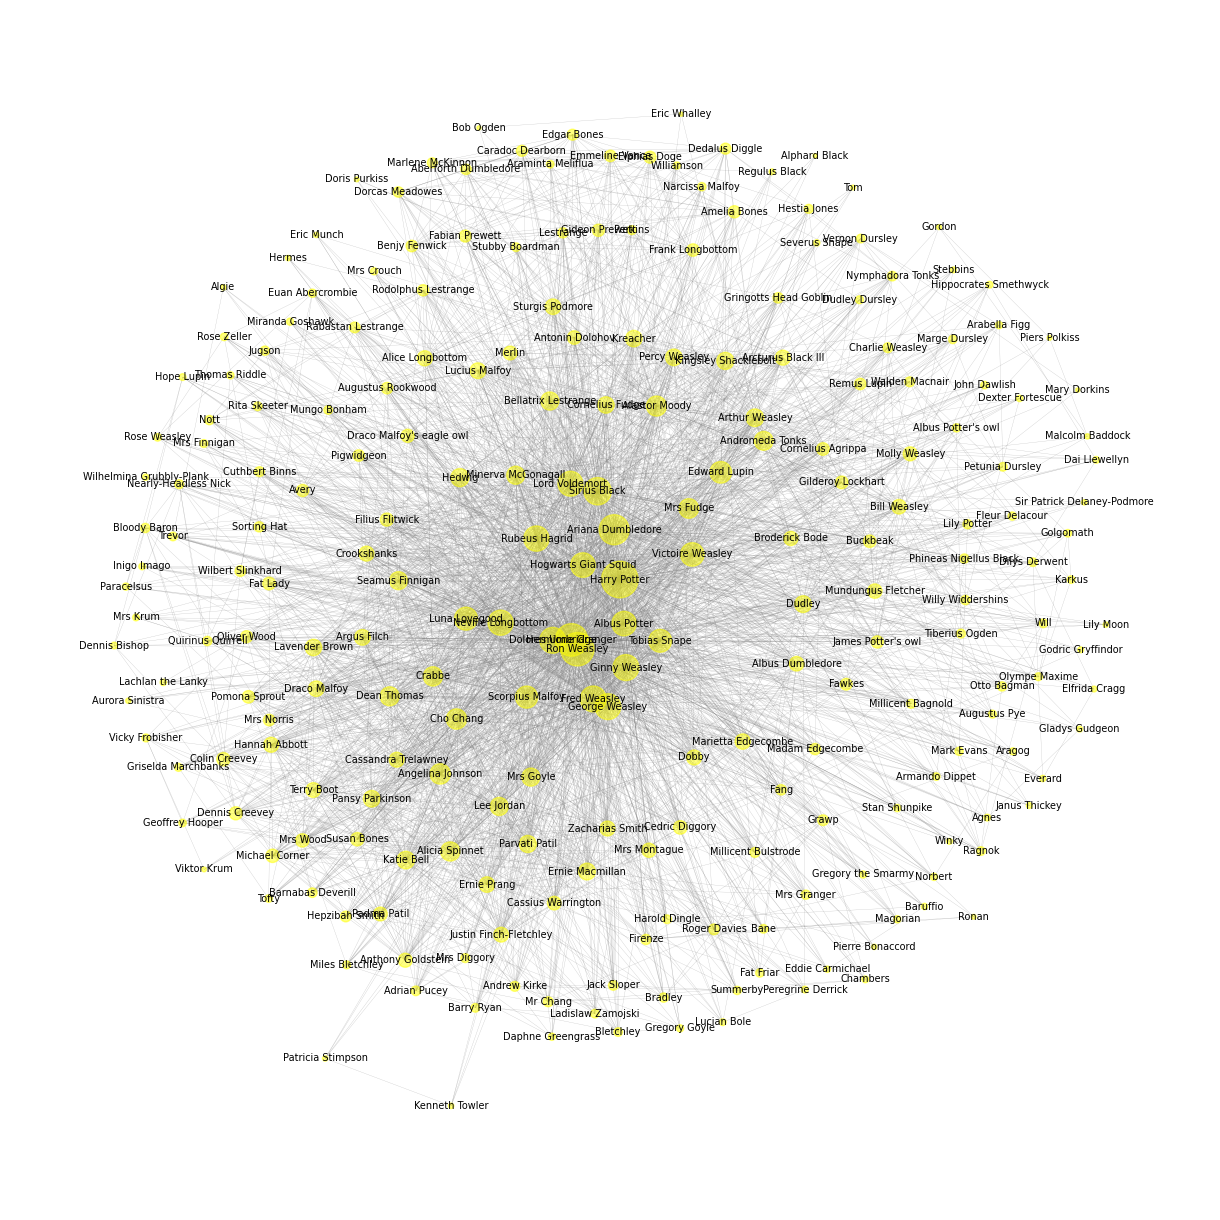

In [169]:
sent_entity_df = find_entities(book_text[6], character_df)
relationships_df = find_relationships(sent_entity_df)
G7 = build_network(relationships_df)

In [170]:
most_degree(G7)

Top 20 nodes by degree:
Harry Potter: 233
Ron Weasley: 193
Hermione Granger: 184
Ariana Dumbledore: 157
Sirius Black: 130
Ginny Weasley: 117
George Weasley: 116
Fred Weasley: 116
Dolores Umbridge: 116
Rubeus Hagrid: 111
Neville Longbottom: 110
Lord Voldemort: 108
Hogwarts Giant Squid: 105
Albus Potter: 104
Victoire Weasley: 96
Luna Lovegood: 92
Tobias Snape: 91
Scorpius Malfoy: 85
Edward Lupin: 81
Cho Chang: 72
Angelina Johnson: 72
Alastor Moody: 70
Mrs Fudge: 67
Crabbe: 65
Alicia Spinnet: 64
Dean Thomas: 63
Andromeda Tonks: 62
Hedwig: 57
Bellatrix Lestrange: 57
Lee Jordan: 57


In [25]:
# Find all relationships involving "Harry Potter"
harry_potter_edges = relationships_df[
    (relationships_df['source'] == "Godric Gryffindor") | 
    (relationships_df['target'] == "Godric Gryffindor")
]

# Print the connections involving "Harry Potter"
print("Connections involving Godric Gryffindor:")
for index, row in harry_potter_edges.iterrows():
    other_character = row['target'] if row['source'] == 'Godric Gryffindor' else row['source']
    print(f"Godric Gryffindor has a relationship with: {other_character}")
    print(f"In sentence: {row['sentence']}\n")


Connections involving Lord Voldemort:
Lord Voldemort has a relationship with: Hermione Granger
In sentence: “No, I just think he’s been very lonely for a long time,” 
said Hermione simply. At this point Mrs. Weasley entered the bedroom 
behind them. “I thought you might be here to tell us to have a 
break!” said Ron bitterly. “D’you know how much 
mold we’ve got rid of since we arrived here?” 

“You were so keen to help the Order,” said Mrs. 
Weasley, “you can do your bit by making 
headquarters fit to live in.” 

“I feel like a house-elf,” grumbled Ron. !” said Hermione hopefully, as Mrs. Weasley 
left them to it again. “You know, maybe it wouldn’t be 
a bad idea to show people exactly how horrible it is to 
clean all the time — we could do a sponsored scrub of 
Gryffindor common room, all proceeds to S.P.E.W., it 
would raise awareness as well as funds — ” 



Page | 204Harry Potter and the Order of the Phoenix - J.K. Rowling 




“I’ll sponsor you to shut up about spew,” Ron 
mutter